<a href="https://colab.research.google.com/github/yehfanju/hello-world/blob/master/ND_Bert_DCard_titles_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCard 標題分類

## 環境設置

In [ ]:
!gdown --id 1BRhhF1TXI8Z2BsSRmv20_ChOFu1r3-QR
!pip install -q -U transformers

Downloading...
From: https://drive.google.com/uc?id=1BRhhF1TXI8Z2BsSRmv20_ChOFu1r3-QR
To: /content/dcard_titles.csv
100% 44.9k/44.9k [00:00<00:00, 40.1MB/s]


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

## 資料前處理

In [ ]:
import pandas as pd
label_enc = LabelEncoder()
titles = pd.read_csv("dcard_titles.csv")
titles = titles.sample(frac=1, random_state=12345)
titles["label"] = label_enc.fit_transform(titles.forum)
titles

,title,forum,label
144,calvin klein的皮帶如何？？,dressup,1
833,#問題 #問題 哪裡可以買砂紙,stationery,8
270,心裡的檻卡住了🥲,relationship,7
468,#免費占卜 #免費八字 幫你卜一卦 第23篇,tarot,9
962,#有雷 拆彈專家2 中性評價,movie,4
...,...,...,...
420,塔羅牌義交流（花影&偉特）,tarot,9
129,靴子怎麼挑？今年流行的妹子感及膝靴腿粗能穿嗎？掌握三點精準挑靴👢,dressup,1
285,無法陪伴對方而產生的罪惡感,relationship,7
485,大眾占卜 一週運勢(01/03-01/09),tarot,9


## 模型定義

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=len(label_enc.classes_))

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
tokenizer(["電影", "五月天"], padding=True, return_tensors="pt")

{'input_ids': tensor([[ 101, 7442, 2512,  102,    0],
        [ 101,  758, 3299, 1921,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1]])}

## 訓練迴圈

In [ ]:
batch_size = 16
n_epoch = 5
torch.manual_seed(12345)

train = titles.iloc[:900]
test = titles.iloc[900:]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.train()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

loss_train = []
acc_train = []
acc_test = []

for epoch_i in range(n_epoch):
  loss_train_batch = []
  acc_train_batch = []

  for idx in range(0, train.shape[0], batch_size):
    optimizer.zero_grad()
    batch = train.iloc[idx:idx+batch_size]
    X = tokenizer(batch.title.tolist(), padding=True, return_tensors="pt").to(device)
    y = torch.tensor(batch.label.tolist(), dtype=torch.long).to(device)
    out = model(**X)
    loss = loss_fn(out.logits, y)
    loss.backward()
    optimizer.step()

    preds = out.logits.argmax(axis=1).detach().cpu().numpy()
    acc = accuracy_score(y.cpu().numpy(), preds)
    loss_train_batch.append(loss.detach().cpu().item())
    acc_train_batch.append(acc)
  
  ## validation
  acc_test_batch = []
  ytrue_test = []
  ypred_test = []
  model.eval()
  for idx in range(0, test.shape[0], batch_size):
    batch = test.iloc[idx:idx+batch_size]
    X = tokenizer(batch.title.tolist(), padding=True, return_tensors="pt").to(device)
    y = torch.tensor(batch.label.tolist(), dtype=torch.long).to(device)
    out = model(**X)

    preds = out.logits.argmax(axis=1).detach().cpu().numpy()
    acc = accuracy_score(y.cpu().numpy(), preds)
    acc_test_batch.append(acc)
    ytrue_test.extend(y.cpu().numpy())
    ypred_test.extend(preds)
  loss_train.append(np.mean(loss_train_batch))
  acc_train.append(np.mean(acc_train_batch))
  acc_test.append(np.mean(acc_test_batch))
  print("[Epoch {}] Train loss: {:.4f}, ".format(epoch_i, loss_train[-1]), end='')
  print("Train Acc: {:.4f}, ".format(acc_train[-1]), end='')
  print("Test Acc: {:.4f}, ".format(acc_test[-1]))

  

[Epoch 0] Train loss: 1.7040, Train Acc: 0.4781, Test Acc: 0.7857, 
[Epoch 1] Train loss: 0.6745, Train Acc: 0.7993, Test Acc: 0.7589, 
[Epoch 2] Train loss: 0.3209, Train Acc: 0.9057, Test Acc: 0.7768, 
[Epoch 3] Train loss: 0.1349, Train Acc: 0.9660, Test Acc: 0.8125, 
[Epoch 4] Train loss: 0.0555, Train Acc: 0.9890, Test Acc: 0.7857, 


## 混淆矩陣

Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.

In [ ]:
confmat = confusion_matrix(ytrue_test, ypred_test)
conf = pd.DataFrame(confmat, index=label_enc.classes_, columns=label_enc.classes_)
row_sum = conf.sum(0)
row_sum.name = "pred_sum"
conf = conf.append(row_sum)
conf["label_sum"] = conf.sum(axis=1)
conf

,boy,dressup,girl,makeup,movie,music,psychology,relationship,stationery,tarot,label_sum
boy,5,0,1,0,0,0,0,1,0,0,7
dressup,0,8,1,0,1,0,1,0,0,0,11
girl,0,1,3,1,1,1,0,2,0,0,9
makeup,0,0,1,13,0,1,0,0,0,0,15
movie,0,0,1,0,4,0,0,1,0,0,6
music,1,0,1,0,1,9,0,0,0,0,12
psychology,0,0,0,0,0,0,13,0,0,0,13
relationship,1,0,2,0,0,0,0,8,0,1,12
stationery,0,0,0,0,0,0,0,0,7,0,7
tarot,0,0,0,0,0,0,1,1,0,6,8


## 預測/推論

In [ ]:
def predict(text):
  X = tokenizer([text], padding=True, return_tensors="pt").to(device)
  out = model(**X)

  probs = out.logits
  preds = probs.argmax(axis=1).detach().cpu().numpy()
  probs = probs.softmax(axis=1).squeeze().detach().cpu().numpy()

  plt.figure(facecolor="white")
  xs = np.arange(len(label_enc.classes_))
  plt.bar(xs, height=probs)
  plt.xticks(xs, labels=label_enc.classes_, rotation=45)
  return label_enc.inverse_transform(preds)[0]

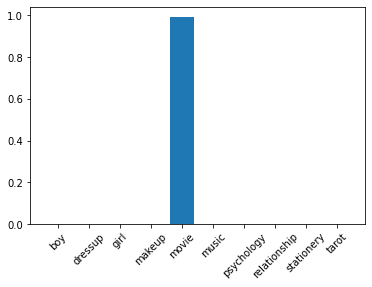

In [ ]:
prob = predict("靈魂急轉彎好看嗎")

'relationship'

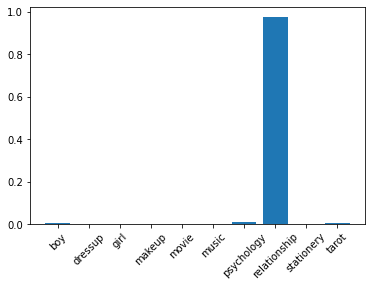

In [ ]:
predict("所有感情問題都建議分手")

'music'

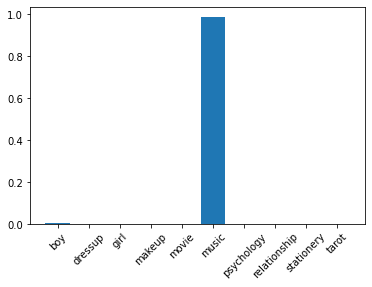

In [ ]:
predict("五月天和蘇打綠")